Purpose of this notebook is to try to learn a few basic things about geopandas. Towards the end of my ebay car sales project I was left with a list of postal codes and average car prices assigned to those codes. **If only there was a way to plot a map of Germany and fill it with colors depending on the average car price in the postal code area...**

In [1]:
#lets start with the easy stuff:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#this part wasn't that easy(give it a go, maybe you won't have any problems, 
#if you're as unlucky as I was, the world of Github and stackoverflow awaits):
import geopandas as gpd
import os

Now to start with, we need a map of Germany. To be precise we need a shapefile of Germany. Shapefile is something geopandas likes to swallow so it can spit out a map. But we are a bit more demenading: we need it with postal codes. Quick google search and voila: https://www.suche-postleitzahl.org/downloads

In [2]:
# From the above link, we've downloaded a file 'plz-gebiete.shp.zip' (because it was the biggest one, my intution
#  din't fail me on that one!)
# now it's almost like pandas dataframe, lets read it, assign it to a GeoDataFrame, and have a look at the first few rows:
data = gpd.read_file('plz-gebiete.shp') 
data.head()

,plz,note,geometry
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ..."
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ..."
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ..."
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ..."
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ..."


column 'plz' is the postal code column, looks like the 'note' column contains the postal code and name of the town/ city/ district? the last column is the shape that geopandas is using to draw a map

In [3]:
# looks almost like a pandas DataFrame, is it though?
type(data)

geopandas.geodataframe.GeoDataFrame

## Is plotting that GeoDataFrame hard?

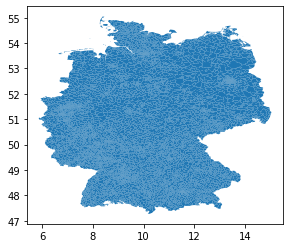

In [4]:
data.plot()
plt.show()

# That was as easy as a basic plot chart!
Can we make it bigger?

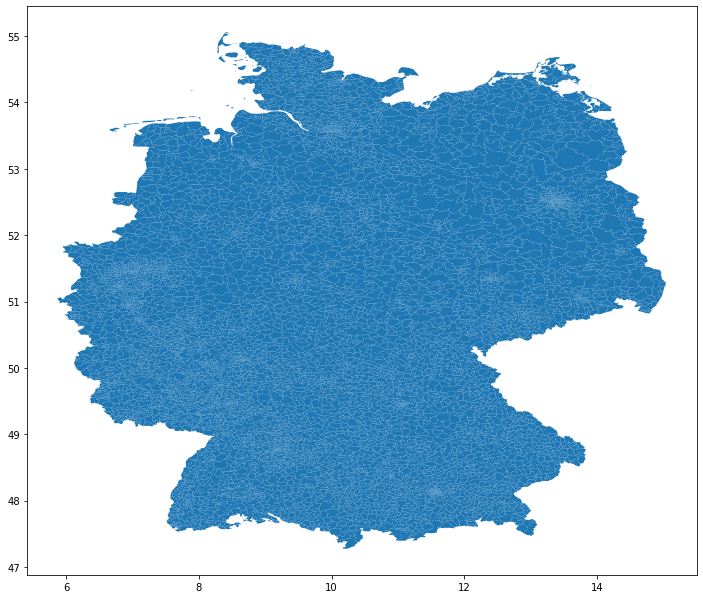

In [5]:
data.plot(figsize=(12,12))
plt.show()

Looks a bit flattened, but we'll deal with that issue later.

# So about those postal codes...
Can we pick one?

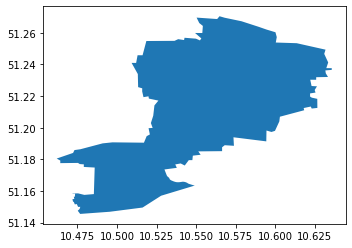

In [6]:
data[data['plz']=='99998'].plot()
plt.show()

# Can we color it?

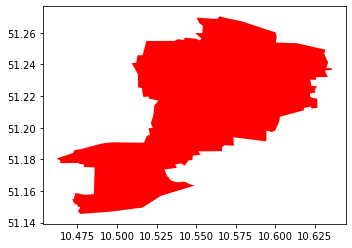

In [7]:
data[data['plz']=='99998'].plot(color='r')
plt.show()

# Ok, so we're gonna need a dataframe with postal codes and prices
As mentioned before, towards **the end of my ebay car sales project** (therefore this data has already been cleaned). Lets read in the dataframe from ebay project (here it's called postal.csv).

In [8]:
autos = pd.read_csv('postal.csv',  encoding="Latin-1")
autos.head()
#remember this?

,Unnamed: 0,date_crawled,name,price,abtest,vehicle_type,registration_year,gearbox,power,model,odometer,registration_month,fuel,brand,unrepaired_damage,ad_created,postal_code,last_seen,engine_size
0,0,2016-03-26,Peugeot_807_160_NAVTECH_ON_BOARD,5000.0,control,bus,2004,manuell,158.000000,andere,150000.0,3,lpg,peugeot,nein,2016-03-26,79588,2016-04-06,NaN
1,1,2016-04-04,BMW_740i_4_4_Liter_HAMANN_UMBAU_Mega_Optik,8500.0,control,limousine,1997,automatik,286.000000,7er,150000.0,6,benzin,bmw,nein,2016-04-04,71034,2016-04-06,NaN
2,2,2016-03-26,Volkswagen_Golf_1.6_United,8990.0,test,limousine,2009,manuell,102.000000,golf,70000.0,7,benzin,volkswagen,nein,2016-03-26,35394,2016-04-06,16.0
3,3,2016-03-12,Smart_smart_fortwo_coupe_softouch/F1/Klima/Pan...,4350.0,control,kleinwagen,2007,automatik,71.000000,fortwo,70000.0,6,benzin,smart,nein,2016-03-12,33729,2016-03-15,NaN
4,4,2016-04-01,Ford_Focus_1_6_Benzin_TÃV_neu_ist_sehr_gepfle...,1350.0,test,kombi,2003,manuell,110.473084,focus,150000.0,7,benzin,ford,nein,2016-04-01,39218,2016-04-01,NaN


# Fun fact: some postal codes in autos.csv are incorrect
Yeah, I know I said the data was clean...
Some of the postal codes have only 4 digits, as I've recently learned to make it a proper German postal code you need a 5 digit code, thus if there's a 4 digit code: We need to add a '0' in front:

In [9]:
autos['postal_code'] = autos['postal_code'].apply(lambda x: '{0:0>5}'.format(x))

# Lets group the data by postal code and calculate average price:

In [10]:
price_post = autos.groupby('postal_code')['price'].mean()

In [11]:
price_post

postal_code
01067    18144.333333
01069     4267.800000
01097     3948.333333
01099     8399.800000
01108     7299.500000
             ...     
99976     5790.000000
99986     3874.250000
99988     5747.000000
99994     6027.500000
99998     2850.000000
Name: price, Length: 6769, dtype: float64

Now, we now that the 'autos' database doesn't cover all of the postal codes from Germany, we're going to need the values for all of the postal codes.

In [12]:
# BTW how much are we missing?
missing = (data.shape[0] - price_post.shape[0]) / data.shape[0] * 100
print('We are missing {} percent of values'.format(round(missing,2)))

We are missing 22.42 percent of values


22%, not bad. Lets create an empty column filled with null:

In [13]:
data['avg_price'] = None

Lets use the data from price_post to fill in the avg_price where we can:

In [14]:
def wha(code):
    if code in price_post:
        return price_post[code]
    else:
        None
data['avg_price'] = data['plz'].apply(wha)

As we can see, we have some missing values in avg_price column. Lets fill them with the price average for the whole autos database:

In [15]:
data['avg_price'] = np.where((data['avg_price'].isnull()==True),autos['price'].mean() ,data['avg_price'])

In [16]:
#anything left?
data['avg_price'].isnull().value_counts()

False    8725
Name: avg_price, dtype: int64

In [17]:
data.head()

,plz,note,geometry,avg_price
0,52538,"52538 Gangelt, Selfkant","POLYGON ((5.86632 51.05110, 5.86692 51.05124, ...",7765.181818
1,47559,47559 Kranenburg,"POLYGON ((5.94504 51.82354, 5.94580 51.82409, ...",4107.800000
2,52525,"52525 Waldfeucht, Heinsberg","POLYGON ((5.96811 51.05556, 5.96951 51.05660, ...",5023.575758
3,52074,52074 Aachen,"POLYGON ((5.97486 50.79804, 5.97495 50.79809, ...",5684.538462
4,52531,52531 Ãbach-Palenberg,"POLYGON ((6.01507 50.94788, 6.03854 50.93561, ...",5285.250000


As we can see above, our GeoDataFrame now has a postal code column, a geometry column(for drawing the map shapes) and an average price column. We can start the magic: 

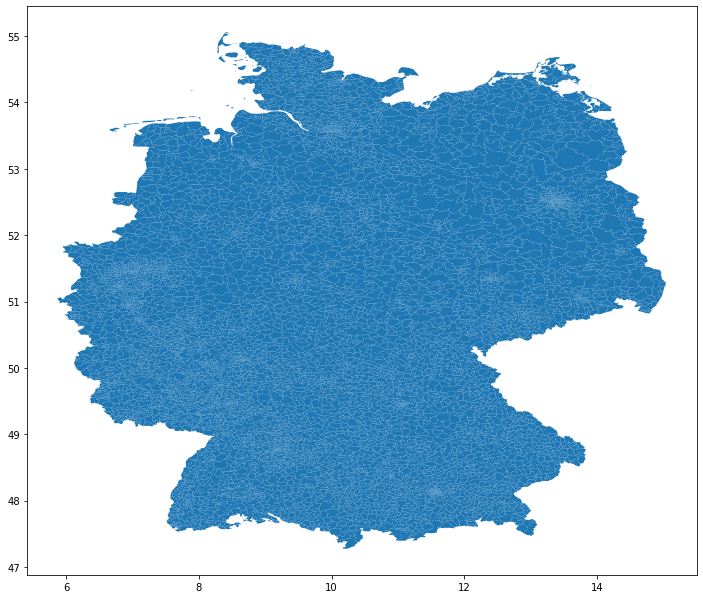

In [18]:
#BTW remember this?
data.plot(figsize=(12,12))
plt.show()

# Lets insert a few extra parameters into that line

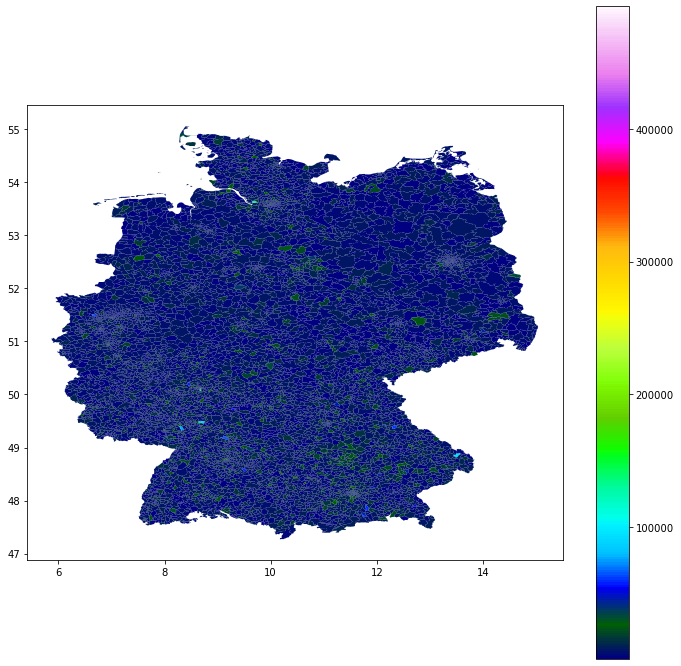

In [19]:
# we want to map the values of avg_price column, and we want a colormap(cmap) of our choosing for that:
data.plot(column="avg_price", figsize=(12,12),cmap="gist_ncar", legend=True)
plt.show()

We're getting somewhere, but what happened? If we look at the legend on the right: most of the cars are way below 100 000 mark, but because we have a few extremely priced entries, our maps colors are the same almost everywhere.

In [20]:
data.sort_values('avg_price')[-5:]

,plz,note,geometry,avg_price
2634,69198,69198 Schriesheim,"POLYGON ((8.63839 49.48762, 8.63847 49.49021, ...",85499.666667
8363,94545,94545 Hohenau,"POLYGON ((13.44401 48.84573, 13.44421 48.84577...",93000.000000
4175,25488,25488 Holm,"POLYGON ((9.64865 53.63185, 9.65603 53.63208, ...",120000.000000
2666,60598,60598 Frankfurt am Main,"POLYGON ((8.65605 50.08187, 8.65651 50.08296, ...",147898.777778
2700,60313,60313 Frankfurt am Main,"POLYGON ((8.67072 50.11556, 8.67073 50.11563, ...",492327.500000


The colormaps range can reach way past 400 000 dollars, but we only have 1 entry in the whole database, above that.
Only 3 entries above the 100 000 dollars! Lets create a copy of the database for everything below 100 000 dollars:

In [21]:
data_below_100 = data[data['avg_price']<100000]

# Lets try again:
While we're at it, lets fix the problem of the map being a bit deformed:

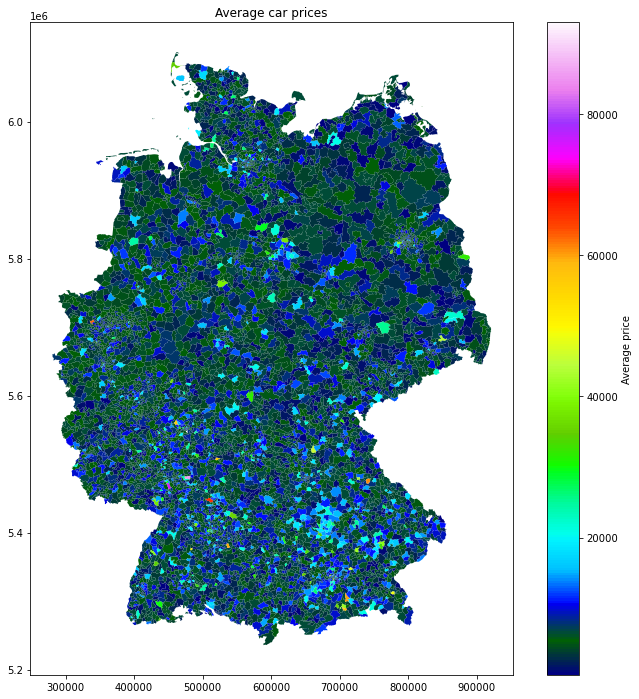

In [34]:
#found this nice piece of code on stackoverflow, 
#when I was looking up 'Plotted map from shape file seems distorted':
map_1 = data_below_100.to_crs({'init' :'epsg:25832'})
#That should solve the problem

map_1.plot(column="avg_price", figsize=(12,12),cmap="gist_ncar", legend=True, 
                    legend_kwds={'label': "Average price"})
plt.title('Average car prices')
plt.show()

Voila!